In [620]:
import PIL
import jax.numpy as jnp
from tensorflow.io import gfile
from scenic.projects.boundary_attention.configs import base_config
from scenic.projects.boundary_attention.helpers import train_utils
from scenic.projects.boundary_attention.helpers import viz_utils

import tensorflow_datasets as tfds
import scenic.projects.boundary_attention.kaleidoshapes.kaleidoshapes

import ml_collections
import jax

from scenic.projects.boundary_attention.dataset_lib import dataloader
from scenic.projects.boundary_attention.configs import kaleidoshapes_config
from scenic.projects.boundary_attention.dataset_lib.datasets import kaleidoshapes_dataset

import matplotlib.pyplot as plt

import numpy as np

import scipy.stats as stats
from os.path import join
import os

In [6]:
class RawPacker:
    def __init__(self, cfa='bayer'):
        self.cfa = cfa

    def pack_raw_bayer(self, cfa_img):
        # pack Bayer image to 4 channels
        img_shape = cfa_img.shape
        H = img_shape[0]
        W = img_shape[1]

        out = np.stack((cfa_img[0:H:2, 0:W:2], # RGBG
                        cfa_img[0:H:2, 1:W:2],
                        cfa_img[1:H:2, 1:W:2],
                        cfa_img[1:H:2, 0:W:2]), axis=0).astype(np.float32)
        return out
    
    def pack_raw_xtrans(self, cfa_img):
        # pack X-Trans image to 9 channels
        img_shape = cfa_img.shape
        H = (img_shape[0] // 6) * 6
        W = (img_shape[1] // 6) * 6

        out = np.zeros((9, H // 3, W // 3), dtype=np.float32)

        # 0 R
        out[0, 0::2, 0::2] = cfa_img[0:H:6, 0:W:6]
        out[0, 0::2, 1::2] = cfa_img[0:H:6, 4:W:6]
        out[0, 1::2, 0::2] = cfa_img[3:H:6, 1:W:6]
        out[0, 1::2, 1::2] = cfa_img[3:H:6, 3:W:6]

        # 1 G
        out[1, 0::2, 0::2] = cfa_img[0:H:6, 2:W:6]
        out[1, 0::2, 1::2] = cfa_img[0:H:6, 5:W:6]
        out[1, 1::2, 0::2] = cfa_img[3:H:6, 2:W:6]
        out[1, 1::2, 1::2] = cfa_img[3:H:6, 5:W:6]

        # 1 B
        out[2, 0::2, 0::2] = cfa_img[0:H:6, 1:W:6]
        out[2, 0::2, 1::2] = cfa_img[0:H:6, 3:W:6]
        out[2, 1::2, 0::2] = cfa_img[3:H:6, 0:W:6]
        out[2, 1::2, 1::2] = cfa_img[3:H:6, 4:W:6]

        # 4 R
        out[3, 0::2, 0::2] = cfa_img[1:H:6, 2:W:6]
        out[3, 0::2, 1::2] = cfa_img[2:H:6, 5:W:6]
        out[3, 1::2, 0::2] = cfa_img[5:H:6, 2:W:6]
        out[3, 1::2, 1::2] = cfa_img[4:H:6, 5:W:6]

        # 5 B
        out[4, 0::2, 0::2] = cfa_img[2:H:6, 2:W:6]
        out[4, 0::2, 1::2] = cfa_img[1:H:6, 5:W:6]
        out[4, 1::2, 0::2] = cfa_img[4:H:6, 2:W:6]
        out[4, 1::2, 1::2] = cfa_img[5:H:6, 5:W:6]

        out[5, :, :] = cfa_img[1:H:3, 0:W:3]
        out[6, :, :] = cfa_img[1:H:3, 1:W:3]
        out[7, :, :] = cfa_img[2:H:3, 0:W:3]
        out[8, :, :] = cfa_img[2:H:3, 1:W:3]
        return out

    def unpack_raw_bayer(self, img):        
        # unpack 4 channels to Bayer image
        img4c = img
        _, h, w = img.shape

        H = int(h * 2)
        W = int(w * 2)

        cfa_img = np.zeros((H, W), dtype=np.float32)

        cfa_img[0:H:2, 0:W:2] = img4c[0, :,:]
        cfa_img[0:H:2, 1:W:2] = img4c[1, :,:]
        cfa_img[1:H:2, 1:W:2] = img4c[2, :,:]
        cfa_img[1:H:2, 0:W:2] = img4c[3, :,:]
        
        return cfa_img

    def unpack_raw_xtrans(self, img):        
        img9c = img
        _, h, w = img.shape
        
        H = int(h * 3)
        W = int(w * 3)

        cfa_img = np.zeros((H, W), dtype=np.float32)

        # 0 R
        cfa_img[0:H:6, 0:W:6] = img9c[0, 0::2, 0::2]
        cfa_img[0:H:6, 4:W:6] = img9c[0, 0::2, 1::2]
        cfa_img[3:H:6, 1:W:6] = img9c[0, 1::2, 0::2]
        cfa_img[3:H:6, 3:W:6] = img9c[0, 1::2, 1::2]

        # 1 G
        cfa_img[0:H:6, 2:W:6] = img9c[1, 0::2, 0::2]
        cfa_img[0:H:6, 5:W:6] = img9c[1, 0::2, 1::2]
        cfa_img[3:H:6, 2:W:6] = img9c[1, 1::2, 0::2]
        cfa_img[3:H:6, 5:W:6] = img9c[1, 1::2, 1::2]

        # 1 B
        cfa_img[0:H:6, 1:W:6] = img9c[2, 0::2, 0::2]
        cfa_img[0:H:6, 3:W:6] = img9c[2, 0::2, 1::2]
        cfa_img[3:H:6, 0:W:6] = img9c[2, 1::2, 0::2]
        cfa_img[3:H:6, 4:W:6] = img9c[2, 1::2, 1::2]

        # 4 R
        cfa_img[1:H:6, 2:W:6] = img9c[3, 0::2, 0::2]
        cfa_img[2:H:6, 5:W:6] = img9c[3, 0::2, 1::2] 
        cfa_img[5:H:6, 2:W:6] = img9c[3, 1::2, 0::2] 
        cfa_img[4:H:6, 5:W:6] = img9c[3, 1::2, 1::2] 

        # 5 B
        cfa_img[2:H:6, 2:W:6] = img9c[4, 0::2, 0::2]
        cfa_img[1:H:6, 5:W:6] = img9c[4, 0::2, 1::2]
        cfa_img[4:H:6, 2:W:6] = img9c[4, 1::2, 0::2]
        cfa_img[5:H:6, 5:W:6] = img9c[4, 1::2, 1::2]

        cfa_img[1:H:3, 0:W:3] = img9c[5, :, :]
        cfa_img[1:H:3, 1:W:3] = img9c[6, :, :]
        cfa_img[2:H:3, 0:W:3] = img9c[7, :, :]
        cfa_img[2:H:3, 1:W:3] = img9c[8, :, :]
        
        return cfa_img    
    
    def pack_raw(self, cfa_img):
        if self.cfa == 'bayer':
            out = self.pack_raw_bayer(cfa_img)
        elif self.cfa == 'xtrans':
            out = self.pack_raw_xtrans(cfa_img)
        else:
            raise NotImplementedError
        return out

    def unpack_raw(self, img):
        if self.cfa == 'bayer':
            out = self.unpack_raw_bayer(img)
        elif self.cfa == 'xtrans':
            out = self.unpack_raw_xtrans(img)
        else:
            raise NotImplementedError        
        return out


class NoiseModelBase:  # base class
    def __call__(self, y, params=None):
        if params is None:
            K, g_scale, saturation_level, ratio = self._sample_params()
        else:
            K, g_scale, saturation_level, ratio = params

        y = y * saturation_level
        y = y / ratio
        
        if 'P' in self.model:
            z = np.random.poisson(y / K).astype(np.float32) * K
        elif 'p' in self.model:
            z = y + np.random.randn(*y.shape).astype(np.float32) * np.sqrt(np.maximum(K * y, 1e-10))
        else:
            z = y

        if 'g' in self.model:
            z = z + np.random.randn(*y.shape).astype(np.float32) * np.maximum(g_scale, 1e-10)  # Gaussian noise

        z = z * ratio
        z = z / saturation_level
        return z


# Only support baseline noise models: G / G+P / G+P* 
class NoiseModel(NoiseModelBase):
    def __init__(self, model='g', cameras=None, include=None, exclude=None, cfa='bayer'):
        super().__init__()
        assert cfa in ['bayer', 'xtrans']
        assert include is None or exclude is None
        self.cameras = cameras or ['CanonEOS5D4', 'CanonEOS70D', 'CanonEOS700D', 'NikonD850', 'SonyA7S2']        

        if include is not None:
            self.cameras = [self.cameras[include]]
        if exclude is not None:
            exclude_camera = set([self.cameras[exclude]])
            self.cameras = list(set(self.cameras) - exclude_camera)

        self.param_dir = 'camera_params'#join('camera_params', 'release')

        print('[i] NoiseModel with {}'.format(self.param_dir))
        print('[i] cameras: {}'.format(self.cameras))
        print('[i] using noise model {}'.format(model))
        
        self.camera_params = {}

        for camera in self.cameras:
            self.camera_params[camera] = np.load(join(self.param_dir, camera+'_params.npy'), allow_pickle=True).item()

        self.model = model
        self.raw_packer = RawPacker(cfa)

    def _sample_params(self):
        camera = np.random.choice(self.cameras)
        # print(camera)

        saturation_level = 16383 - 800
        profiles = ['Profile-1']

        camera_params = self.camera_params[camera]
        Kmin = camera_params['Kmin']
        Kmax = camera_params['Kmax']
        profile = np.random.choice(profiles)
        camera_params = camera_params[profile]

        log_K = np.random.uniform(low=np.log(Kmin), high=np.log(Kmax))
        #log_K = np.random.uniform(low=np.log(1e-1), high=np.log(30))
        
        log_g_scale = np.random.standard_normal() * camera_params['g_scale']['sigma'] * 1 +\
             camera_params['g_scale']['slope'] * log_K + camera_params['g_scale']['bias']

        K = np.exp(log_K)
        g_scale = np.exp(log_g_scale)

        ratio = np.random.uniform(low=100, high=300)

        return (K, g_scale, saturation_level, ratio)


In [50]:
def apply_noise(img, sigma):
    return img + np.random.normal(0, sigma, img.shape) 

In [311]:
def prep_img(input_img, noise_model, out_shape = (125,125)):
    return jnp.clip(jnp.array(noise_model(input_img)),0,1)


In [630]:
def create_batch(img_path, output_path, boundary_model, noise_lvls = [0.2,0.3,0.4,0.5], num_per_lvl = 5, img_shape = (150,150)):
    os.mkdir(output_path)

    clean_img = PIL.Image.open(gfile.GFile(img_path, 'rb')).resize(img_shape)

    clean_img.save(f'{output_path}/clean_img.png')

    clean_img = jnp.array(clean_img)/255.0

    input_clean_img = jnp.expand_dims(clean_img.transpose(2,0,1)[:3,:,:], axis=0)

    outputs_clean = boundary_model[0](boundary_model[1]['params'], input_clean_img)

    clean_boundaries = outputs_clean[-1]['global_boundaries'].squeeze()

    img_out = PIL.Image.fromarray((np.array(clean_boundaries)*255).astype(np.uint8))

    img_out.save(f'{output_path}/clean_img_boundaries.png')
    for sigma in noise_lvls:
        noise_fun = lambda x, s: jnp.clip(jnp.array(x + np.random.normal(0, s, x.shape)), 0, 1)

        os.mkdir(f'{output_path}/noise_lvl_{sigma}/')
        for i in range(num_per_lvl):
            noisy_img = noise_fun(clean_img, sigma)

            input_noisy_img = jnp.expand_dims(noisy_img.transpose(2,0,1)[:3,:,:], axis=0)

            outputs_noisy = boundary_model[0](boundary_model[1]['params'], input_noisy_img)

            noisy_boundaries = outputs_noisy[-1]['global_boundaries'].squeeze()

            img_out = PIL.Image.fromarray((np.array(noisy_boundaries)*255).astype(np.uint8))

            img_out.save(f'{output_path}/noise_lvl_{sigma}/img_boundaries_noisy_{i}.png')
                

In [632]:
weights_dir = 'scenic/projects/boundary_attention/pretrained_weights/' # Add path to pretrained weights here

im_height = 150 # Replace with height to resize input to
im_width = 150  # Replace with width to resize input to

config = base_config.get_config(model_name='boundary_attention',
                                  dataset_name='testing',
                                  input_size=(im_height, im_width, 3))

apply_jitted, trained_params = train_utils.make_apply(config, weights_dir)

In [634]:
create_batch('142.jpg', 
             'test/', 
             (apply_jitted, trained_params), 
             noise_lvls=[0.3,0.4], 
             num_per_lvl=2, 
             img_shape=(150,150))

In [315]:
input_img = jnp.array(PIL.Image.open(gfile.GFile('soccer.jpg', 'rb')))
print(input_img.shape)

(225, 225, 3)


In [431]:
nm = NoiseModel(model = "G+P*")

fun = lambda x: x + np.random.normal(0, 0.3, x.shape)

img_path = '142.jpg' # Replace with path to new input

clean_img = jnp.array(PIL.Image.open(gfile.GFile(img_path, 'rb')).resize((150,150)))/255.0
noisy_img = prep_img(img_path, fun , (150,150))
noisy_img_2 = prep_img(img_path, fun , (150,150))

[i] NoiseModel with camera_params
[i] cameras: ['CanonEOS5D4', 'CanonEOS70D', 'CanonEOS700D', 'NikonD850', 'SonyA7S2']
[i] using noise model G+P*


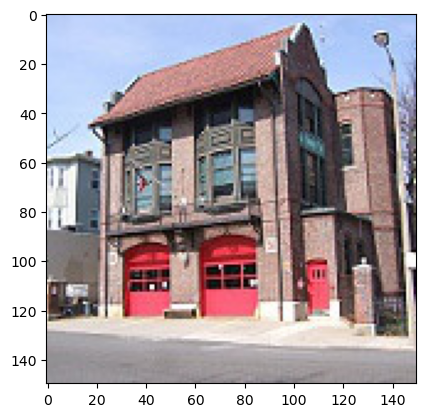

In [433]:
plt.imshow(clean_img)

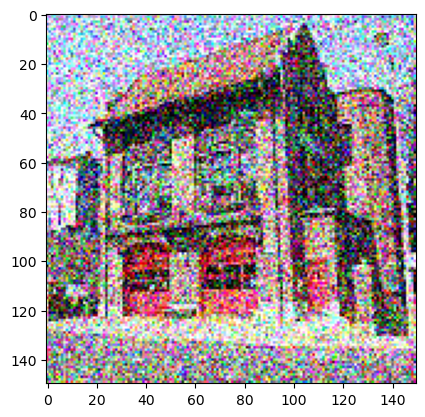

In [434]:
plt.imshow(noisy_img)

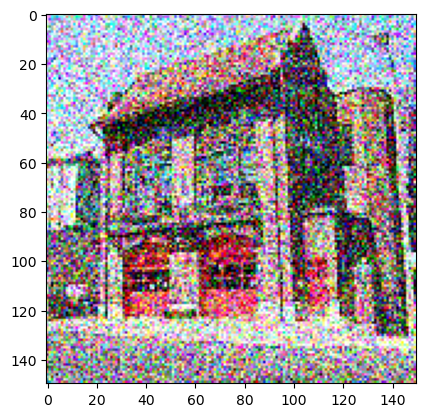

In [435]:
plt.imshow(noisy_img_2)

In [439]:
input_noisy_img_1 = jnp.expand_dims(noisy_img.transpose(2,0,1)[:3,:,:], axis=0)
input_noisy_img_2 = jnp.expand_dims(noisy_img_2.transpose(2,0,1)[:3,:,:], axis=0)
input_clean_img = jnp.expand_dims(clean_img.transpose(2,0,1)[:3,:,:], axis=0)

outputs_noisy_1 = apply_jitted(trained_params['params'], input_noisy_img_1)

outputs_noisy_2 = apply_jitted(trained_params['params'], input_noisy_img_2)

outputs_clean = apply_jitted(trained_params['params'], input_clean_img)

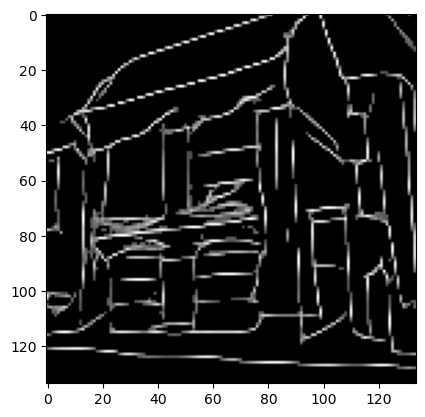

In [440]:
#boundaries = outputs[-1]['global_boundaries'].squeeze()

boundaries_clean = (outputs_clean[-1]['global_boundaries'].squeeze() * (
      outputs_clean[-1]['global_boundaries'].squeeze() > 0.3))[8:-8, 8:-8]

plt.imshow(boundaries_clean, cmap = "grey")

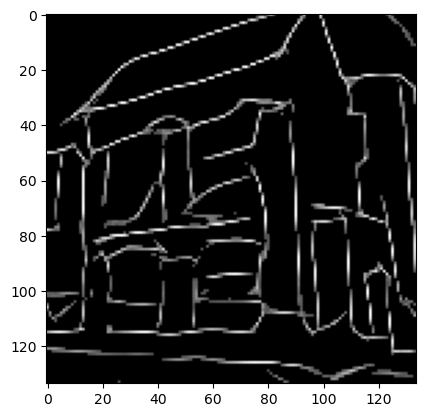

In [441]:
#boundaries = outputs[-1]['global_boundaries'].squeeze()

boundaries_noisy_1 = (outputs_noisy_1[-1]['global_boundaries'].squeeze() * (
      outputs_noisy_1[-1]['global_boundaries'].squeeze() > 0.3))[8:-8, 8:-8]

plt.imshow(boundaries_noisy_1, cmap = "grey")

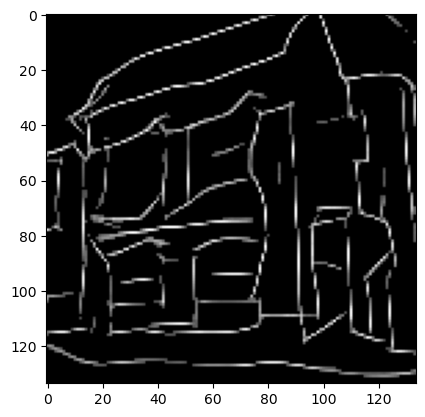

In [442]:
boundaries_noisy_2 = (outputs_noisy_2[-1]['global_boundaries'].squeeze() * (
      outputs_noisy_2[-1]['global_boundaries'].squeeze() > 0.3))[8:-8, 8:-8]

plt.imshow(boundaries_noisy_2, cmap = "grey")

In [474]:
out = ((outputs_clean[-1]['global_boundaries'].squeeze() > 0.2)[8:-8, 8:-8],
       (outputs_noisy_1[-1]['global_boundaries'].squeeze() > 0.2)[8:-8, 8:-8],
       (outputs_noisy_2[-1]['global_boundaries'].squeeze() > 0.2)[8:-8, 8:-8])

(-0.5, 133.5, 133.5, -0.5)

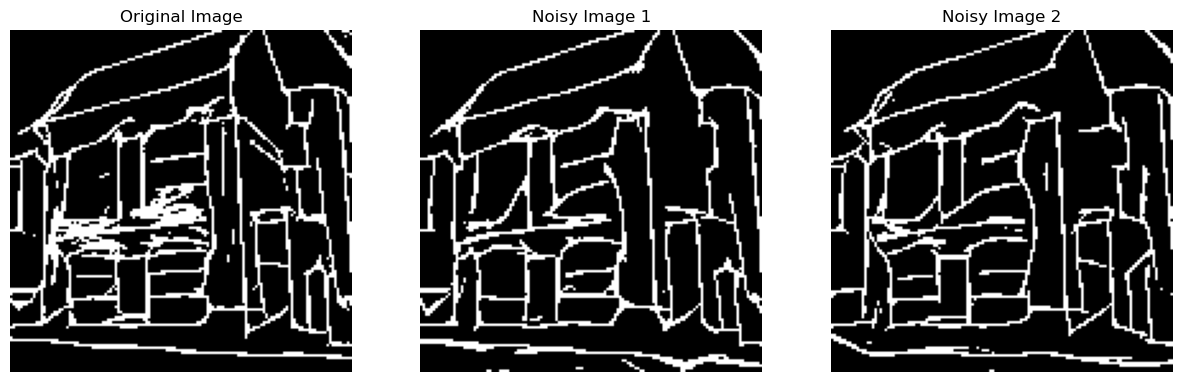

In [475]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
#plt.subplots_adjust(wspace=-0.55, hspace=0.2)
    
ax[0].imshow(out[0], cmap = "grey")
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(out[1], cmap = "grey")
ax[1].set_title(f'Noisy Image 1')
ax[1].axis('off')

ax[2].imshow(out[2], cmap = "grey")
ax[2].set_title(f'Noisy Image 2')
ax[2].axis('off')

In [599]:
img = PIL.Image.fromarray((np.array(outputs_clean[-1]['global_boundaries'].squeeze())*255).astype(np.uint8))

In [606]:
img.save("img1.png")